In [1]:
import tf_glove

# Instantiating the model

To create a new GloVe model, simply call `tf_glove.GloVeModel()`:

In [2]:
model = tf_glove.GloVeModel(embedding_size=104, context_size=30)



`GloVeModel()` has several parameters:
- **`embedding_size`**: the target dimensionality of the trained word representations. Typically between 50 and 300.
- **`context_size`**: how many tokens on either side of a given word to include in each context window. Can be either a tuple of two ints, indicating how many token on the left and right to include, or a single int, which will be interpreted to mean symmetric context.
- **`max_vocab_size`** *(Optional)*: the maximum size of the model's vocabulary. The model's vocabulary will be the most frequently occurring words in the corpus up to this amount. The default is 100,000.
- **`min_occurrences`** *(Optional)*: the minimum number of times a word must have appeared in the corpus to be included in the model's vocabulary. Default is 1.
- **`scaling_factor`** *(Optional)*: the alpha term in Eqn. 9 of Pennington et al.'s paper. Default is 3/4, which is the paper's recommendation
- **`cooccurrence_cap`** *(Optional)*: the x_max term in Eqn. 9 of Pennington et al.'s paper. Default is 100, which is the paper's recommendation
- **`batch_size`** *(Optional)*: the number of cooccurrences per minibatch of in training. Default is 512, which seems to work well on my machine. If training is very slow, consider playing with this.
- **`learning_rate`** *(Optional)*: the Adagrad learning rate used in training. Default is 0.05, which is the paper's recommendation

# Reading the corpus

tf_glove needs to be fit to a corpus in order to learn word representations. To do this, we'll use `GloVeModel.fit_to_corpus(corpus)`. This method expects an iterable of iterables of strings, where each string is a token, like this:

`[["this", "is", "a", "comment", "."], ["this", "is", "another", "comment", "."]]`

That was a list of lists, but any iterable of iterables of strings should work.

### Note on getting the dataset (if you want to follow along with these examples exactly)

For these examples, I'm going to use the dataset of Reddit comments described here: https://www.reddit.com/r/datasets/comments/3bxlg7/i_have_every_publicly_available_reddit_comment

tf_glove is designed to work with any corpus, so there's no need to download this dataset. However, if you'd like to, that post has a link to a torrent for all of the comments as well as a link for just the comments from January 2015. Even just the January 2015 file is quite large (~5 GB).

I downloaded it and used

`$ head -n 1000000 RC_2015-01 > /path/to/RC_2015-01-1m_sample`

to get the 1 million comment sample file referenced below. You could also use 100k if you want to save some time. 1 million comments takes ~15 minutes to fit on my machine.

## The code:

In [18]:
import nltk
import re
import pandas as pd
import numpy as  np


def get_corpus_from_csv(filename,delimeter):
    coments = pd.read_csv(filename,sep=delimeter)
    corpus = []
    for i in range(len(coments)):
        oraciones = []
        sentence = coments.translation.iloc[i]
        sentence = sentence.split(' ')
        for word in sentence:
            if word != "[SILENCE]":
                word = word.replace('.','')
                word = word.replace(',','')
                word = word.replace('?','')
                word = word.lower()
                oraciones.append(word)
        corpus.append(oraciones)
    return corpus
filename = "train.sentences.pronunciations.multi.translations.csv"
delimiter = ';'

def get_corpus_distinct_from_corpus(corpus):
    corpus_distint = []
    for sentence in corpus:
        for word in sentence:
            if word not in corpus_distint:
                corpus_distint.append(word)
    return corpus_distint

corpus = get_corpus_from_csv(filename,delimiter)
corpus_distinct = get_corpus_distinct_from_corpus(corpus)

Now, to fit the model to the corpus:

In [19]:
model.fit_to_corpus(corpus)


# Training the model

GloVeModel.fit_to_corpus() builds the vocabulary and cooccurrence matrix that will be used in training, but it doesn't actually train the word representations. It's time to kick off TensorFlow and train the model for real:

In [20]:
model.train(num_epochs=500)

`GloVeModel.train()` has a few parameters:
- **`num_epochs`**: How many passes through the cooccurrence matrix the training should make. The paper recommends at least 50 for `embedding_size` < 300, and 100 otherwise.
- **`log_dir`** *(Optional)*: The path of the directory in which to log summaries for TensorBoard and t-SNE visualizations. Default is `None`, i.e. don't log anything.
- **`summary_batch_interval`** *(Optional)*: How many minibatches between logging events for TensorBoard. Default is 1000.
- **`tsne_epoch_interval`** *(Optional)*: How many epochs (full passes through cooccurrence matrix) between outputting a t-SNE visualization of the model's embeddings for the most frequent 1000 words in the vocabulary. Default is None, i.e. don't output t-SNE visualizations during training.

# Checking out the results

Now that we've trained the model, let's look at the results.

Use `GloVeModel.embedding_for()` to get the trained embedding for a single word:

In [10]:
model.embedding_for("john").reshape(1,104)

array([[ 1.4101266 ,  0.15728313,  1.5777141 , -0.6432649 ,  1.5935396 ,
         1.4316278 , -0.8744687 , -0.51070315,  1.4835567 ,  0.29280904,
         0.26273292,  0.25245503, -0.2456733 ,  0.04399741, -0.6484251 ,
         0.45285904,  0.80858946,  0.1971547 , -0.03159156,  0.86223376,
        -0.25904372,  1.0218524 , -0.5100661 , -0.43457538, -0.6530937 ,
        -0.4409223 , -0.42464173, -0.07745256,  1.401341  ,  0.524408  ,
         0.3096601 , -0.1421004 ,  0.77081007,  0.10705495, -0.3971895 ,
         0.7201324 ,  0.42013776, -0.88541037, -1.5703957 ,  0.7293607 ,
        -1.009845  ,  1.2401724 ,  0.04732007, -0.22432917,  1.4266188 ,
        -1.0241297 , -1.0483317 ,  1.7095056 , -0.9534742 ,  1.4140134 ,
        -0.0860582 ,  0.98583484, -0.29128727, -1.0226429 ,  0.5129814 ,
         0.06009402,  0.29051608,  0.07949501,  0.8656765 , -0.84392923,
         0.6279558 ,  0.23443922,  1.2492037 , -0.9826825 ,  1.4972818 ,
         0.6748134 , -0.37852377,  0.760955  ,  0.3

You can also get the model's embeddings for every word in the vocabulary like this:

In [11]:
model.embeddings[1].shape

(104,)

`GloVeModel.embeddings` will give you a NumPy matrix where each row is the model's embedding for a single word.

To make use of this, you'll want to know what row corresponds to a particular word. You can do that with `GloVeModel.id_for_word`:

In [12]:
model.embeddings[model.id_for_word('man')]

array([ 0.17206779, -1.0310005 , -0.54505   , -0.8358382 , -0.29282343,
        0.58336514, -0.4782384 , -0.79293394, -0.407309  ,  0.09400146,
        0.11450028,  0.21486261,  0.4738555 ,  1.2994531 , -1.7106441 ,
       -1.054503  ,  1.1483448 , -0.00900716,  0.94000685,  0.6218355 ,
        0.4881785 ,  0.10372198, -0.6524633 , -0.94285965, -0.7259998 ,
       -0.29877728, -0.9744507 ,  0.7210448 ,  0.31809977,  0.34674126,
       -0.77602106,  0.4878053 ,  0.71509236,  0.01537687, -0.21728463,
        0.90593433, -1.4091353 , -0.6958827 , -1.2228165 ,  1.5709469 ,
       -0.02232337, -0.20088756,  1.3288479 , -0.04292315, -0.50256956,
       -0.25093278,  0.29168814, -0.12444943, -0.850189  , -0.7260375 ,
        0.35312465,  0.43111148, -0.15756905, -0.16591066, -0.6937022 ,
       -1.1194332 , -0.45190313,  0.68586266,  0.30495048,  0.19691947,
        0.6488329 , -0.03358632, -0.6747047 ,  0.95292443, -0.31431744,
        0.01018101,  0.42350835,  0.57158035,  1.0913311 ,  0.07

And if you want to see a 2D visualization of the learned vector space, you can use `GloVeModel.generate_tsne()`:

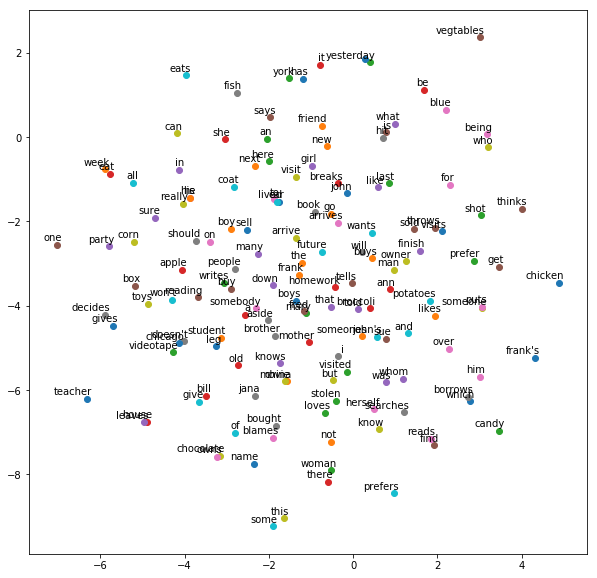

In [13]:
%matplotlib inline
model.generate_tsne(size=(10,10))

You might want to open that image in a new tab.

With no parameters, `GloVeModel.generate_tsne()` can be used interactively like in this notebook, but it also has parameters that will let you save the visualization to a file and adjust the size of the image and how many words appear:

- **`path`** *(Optional)*: The path at which to save the generated PNG image. Default is None, which only really makes sense for interactive environments.
- **`size`** *(Optional)*: A tuple of (width, height) in *inches*. (Yeah, I know right? This is inherited from matplotlib.) Default is 100 x 100.  
- **`word_count`** *(Optional)*: How many words to plot in the visualization. Default is 1000, which works fairly well for a (100 x 100) visualization.


In [27]:
def generate_embeddings_dict(corpus_distinct):
    glove_embeddings = {}
    for word in corpus_distinct:
        print("The following is the glove embedding for: \"{}\" ".format(word))
        print(model.embedding_for(word))
        print("*******************************************************************************************")
        glove_embeddings[word] = model.embedding_for(word)
    return glove_embeddings
glove_embeddings = generate_embeddings_dict(corpus_distinct)

The following is the glove embedding for: "john" 
[ 0.17595327  0.53670037 -0.40529025  0.5557694   0.17051238  0.13549712
  0.49557912 -0.49786934  0.866816   -1.192246   -0.3605091   0.82379186
  0.16567755 -0.21895278 -0.5924994   0.16050085 -0.29053003  1.2824668
 -0.63347137  0.91412127  0.05244389  0.683336    0.2013829   0.20926076
 -0.17396206  0.01861033 -0.28730425  0.31889665 -0.23886523 -1.2723076
 -0.24299186  0.8261621  -1.1420778  -0.8583378  -0.42592406  0.07599513
 -0.03504801 -0.5637387   0.83910394 -0.27708152  1.3497953   0.09465805
 -1.1493794  -0.17918153  0.9974611  -0.57056516 -0.11882337  0.45400417
  0.01246622 -0.14987458 -0.99966586 -0.6985497  -0.36514255 -0.2634048
 -0.5287571  -1.2561429  -0.7315115  -1.1492996  -0.8539867  -1.2472341
  0.5337614   0.7704278   0.23693481 -1.2805372  -0.217882   -0.54443455
 -0.2514675   0.309043   -0.968292   -0.32320765 -0.2916851   0.09554861
  0.49297464  1.0908777  -0.6347295  -0.18107069  1.4380233   0.1239754
  0.28

array([ 0.17595327,  0.53670037, -0.40529025,  0.5557694 ,  0.17051238,
        0.13549712,  0.49557912, -0.49786934,  0.866816  , -1.192246  ,
       -0.3605091 ,  0.82379186,  0.16567755, -0.21895278, -0.5924994 ,
        0.16050085, -0.29053003,  1.2824668 , -0.63347137,  0.91412127,
        0.05244389,  0.683336  ,  0.2013829 ,  0.20926076, -0.17396206,
        0.01861033, -0.28730425,  0.31889665, -0.23886523, -1.2723076 ,
       -0.24299186,  0.8261621 , -1.1420778 , -0.8583378 , -0.42592406,
        0.07599513, -0.03504801, -0.5637387 ,  0.83910394, -0.27708152,
        1.3497953 ,  0.09465805, -1.1493794 , -0.17918153,  0.9974611 ,
       -0.57056516, -0.11882337,  0.45400417,  0.01246622, -0.14987458,
       -0.99966586, -0.6985497 , -0.36514255, -0.2634048 , -0.5287571 ,
       -1.2561429 , -0.7315115 , -1.1492996 , -0.8539867 , -1.2472341 ,
        0.5337614 ,  0.7704278 ,  0.23693481, -1.2805372 , -0.217882  ,
       -0.54443455, -0.2514675 ,  0.309043  , -0.968292  , -0.32